In [1]:
import pandas as pd
import numpy as np

Load file

In [2]:
excelfile = "C:/Users/igorp/Downloads/manual_results_0.28_70.00_40.00_LVMYO_HEX8_83648_wr.xlsx"

In [3]:
xls = pd.ExcelFile(excelfile)

# prep for storing groups
sb_endo_group = []
sb_epi_group = []
l1_group = []

base_group = []
apex_group = []

# read groups
for k in ["X", "Y", "Z"]:
    sb_endo_group.append(pd.read_excel(xls, 'SB-ENDO-{}'.format(k)))
    sb_epi_group.append(pd.read_excel(xls, 'SB-EPI-{}'.format(k)))
    l1_group.append(pd.read_excel(xls, 'L1-{}'.format(k)))
    
    base_group.append(pd.read_excel(xls, 'BASE-{}'.format(k)))
    apex_group.append(pd.read_excel(xls, 'APEX-{}'.format(k)))

from_code = pd.read_excel(xls, 'from_code')

xls.close()

Transform dfs data into xyz arrays

In [4]:
def transform_to_xyz_arr(group_data):
    arr = np.asarray([df.values[:, 1:] for df in group_data])
    return arr.swapaxes(0, 1).swapaxes(1, 2)

In [5]:
sb_endo = transform_to_xyz_arr(sb_endo_group)
sb_epi = transform_to_xyz_arr(sb_epi_group)
l1 = transform_to_xyz_arr(l1_group)

base = transform_to_xyz_arr(base_group)
apex = transform_to_xyz_arr(apex_group)

Compute centroids

In [6]:
def centroid(points, filter=True, ql=0.01, qh=0.99):

    if filter:
        # remove outliers in x, y and z directions
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        low_x = np.quantile(x, ql)
        high_x = np.quantile(x, qh)
        low_y = np.quantile(y, ql)
        high_y = np.quantile(y, qh)
        low_z = np.quantile(z, ql)
        high_z = np.quantile(z, qh)
        filter = np.where((x >= low_x) & (x <= high_x) &
                        (y >= low_y) & (y <= high_y) &
                        (z >= low_z) & (z <= high_z)
                        )[0]
        bound_points = points[filter]
        if len(bound_points) == 0:
            bound_points = points
    else:
        bound_points = points
    # compute centroid based on mean of extremas
    x = bound_points[:, 0]
    y = bound_points[:, 1]
    z = bound_points[:, 2]

    c = np.zeros(3)
    c[0] = (np.max(x) + np.min(x)) * 0.5
    c[1] = (np.max(y) + np.min(y)) * 0.5
    c[2] = (np.max(z) + np.min(z)) * 0.5

    return c

In [7]:
# sb_endo_center = np.asarray([centroid(x) for x in sb_endo])
# sb_epi_center = np.asarray([centroid(x) for x in sb_epi])
base_center = np.asarray([centroid(x) for x in base])
apex_center = np.asarray([centroid(x) for x in apex])

In [8]:
df_comp = pd.DataFrame()
df_comp["timesteps"] = sb_endo_group[0]["timesteps"]

Compute longitudinal distance (Base->Apex)

In [9]:
ld = np.linalg.norm(base_center - apex_center, axis=1)
df_comp["ld_manual"] = ld
df_comp["ld_code"] = from_code["longitudinal_distance_endo"]

<AxesSubplot:xlabel='timesteps'>

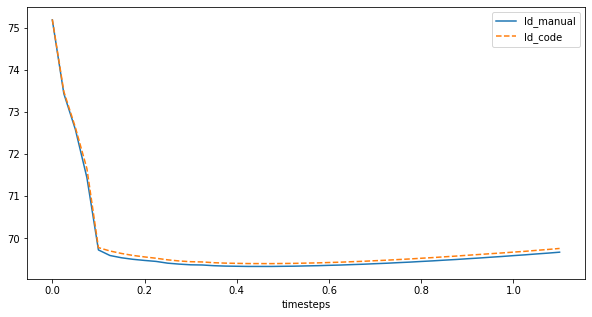

In [10]:
df_comp.plot(x="timesteps", y=["ld_manual", "ld_code"], style=["-", "--"], figsize=(10,5))

Compute radial distance

In [11]:
def dist_from_line(p1:np.ndarray, p2:np.ndarray, p3:np.ndarray, dtype:np.dtype=np.float64) -> np.ndarray:
    """Computes the perpendicular distance between one or multiple points [p1] to a line (or lines) \
        defined by [p2, p3]. p2 and p3 must have same shape. points are defined as: [x,y,z].

    Args:
        p1 (np.ndarray): Reference point(s)
        p2 (np.ndarray): First point on line(s)
        p3 (np.ndarray): Second point on line(s)
        dtype (np.dtype, optional): Values are converted to numpy array. This denies the output type. Defaults to np.float64.

    Returns:
        float or np.ndarray: Perpendicular distance(s). If singular point and line, will return float. Otherwise will return an array.
    """
    assert len(p2) == len(p3), "p2 and p3 must have same number of points as they represent lines. Received: p2 ({}), p3 ({})".format(len(p2), len(p3))
    if not isinstance(p1, np.ndarray):
        p1 = np.asarray(p1, dtype=dtype)
        assert p1.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p1): {}".format(p1.shape)
    if not isinstance(p2, np.ndarray):
        p2 = np.asarray(p2, dtype=dtype)
        assert p2.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p2): {}".format(p2.shape)
    if not isinstance(p3, np.ndarray):
        p3 = np.asarray(p3, dtype=dtype)
        assert p3.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p3): {}".format(p3.shape)

    dists = np.linalg.norm(np.cross(p3-p2, p2-p1, axis=-1), axis=-1)/np.linalg.norm(p3-p2, axis=-1)
    # dists = np.linalg.norm(np.cross(p2-p1, p1-p3, axis=-1), axis=-1)/np.linalg.norm(p2-p1, axis=-1)
    return dists.astype(dtype)

In [12]:
rd_endo = []
rd_epi = []
for i in range(45):
    # rs_endo = np.linalg.norm(sb_endo[i, :] - sb_endo_la_center[i], axis=1)
    rd_endo.append(dist_from_line(sb_endo[i], base_center[i], apex_center[i]))
    rd_epi.append(dist_from_line(sb_epi[i], base_center[i], apex_center[i]))
    
rd_endo = np.mean(rd_endo, axis=1)
rd_epi = np.mean(rd_epi, axis=1)

df_comp["rd_endo_manual"] = rd_endo
df_comp["rd_endo_code"] = from_code["radial_distance_endo_superbase"]

df_comp["rd_epi_manual"] = rd_epi
df_comp["rd_epi_code"] = from_code["radial_distance_epi_superbase"]

<AxesSubplot:xlabel='timesteps'>

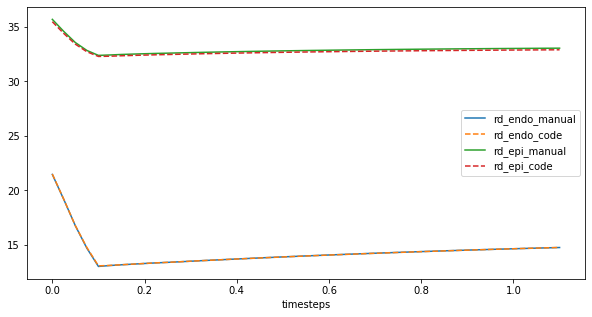

In [13]:
df_comp.plot(
    x="timesteps", 
    y=["rd_endo_manual", "rd_endo_code", "rd_epi_manual", "rd_epi_code"], 
    style=["-", "--", "-", "--"],
    figsize=(10,5))

Compute wall thickness

In [14]:
wt = rd_epi - rd_endo
df_comp["wt_manual"] = wt
df_comp["wt_code"] = from_code["wall_thickness_superbase"]

<AxesSubplot:xlabel='timesteps'>

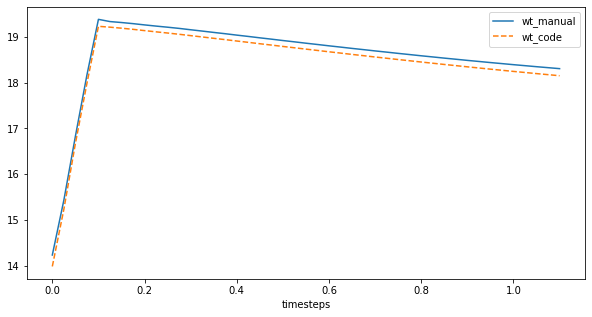

In [15]:
df_comp.plot(
    x="timesteps", 
    y=["wt_manual", "wt_code"], 
    style=["-", "--"],
    figsize=(10,5))

Compute circumferential length

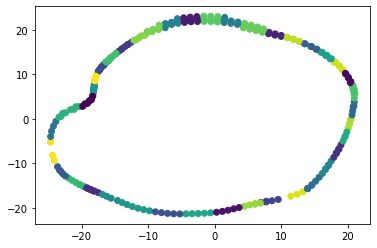

In [16]:
from sklearn.cluster import KMeans

n_clusters = 40
clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(sb_endo[0, :, :2])
labels = clustering.labels_

centers = []
for k in range(n_clusters):
    mask = np.where(labels==k)[0]
    centers.append([np.mean(x[mask], axis=1) for x in sb_endo])

from matplotlib import pyplot as plt
plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)
# plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)


In [17]:
def sort_by_spherical(xyz):
    # transform to spherical coordinates
    rs = np.linalg.norm(xyz, axis=1)
    thetas = np.arccos(xyz[:, 2]/rs)
    phis = np.arctan2(xyz[:, 1],xyz[:, 0])
    # sort by columns
    ids = np.lexsort((rs, thetas, phis))
    return xyz[ids]

In [18]:
centers = []
for x in sb_endo:
    c = np.asarray([np.mean(x[np.where(labels==k)[0]], axis=0) for k in range(n_clusters)])
    centers.append(sort_by_spherical(c))
centers = np.asarray(centers)

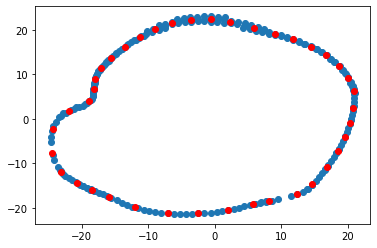

In [19]:
plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1])
plt.scatter(centers[0, :, 0], centers[0, :, 1], c="red")

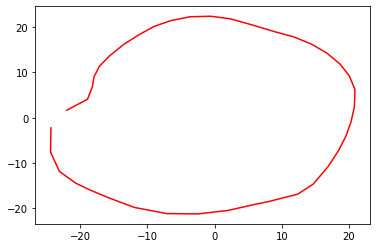

In [20]:
plt.plot(centers[0, :, 0], centers[0, :, 1], c="red")

In [21]:
def line_sum(coords, join_ends=False):
    if not join_ends:
        return np.sum(np.linalg.norm(coords[1:]-coords[:-1], axis=1))
    else:
        _coords = np.vstack((coords, coords[0]))
        return np.sum(np.linalg.norm(_coords[1:]-_coords[:-1], axis=1))


In [22]:
sc = np.asarray([line_sum(x, join_ends=True) for x in centers])
df_comp["sc_manual"] = sc
df_comp["sc_code"] = from_code["global_circumferential_length_endo_superbase"]

<AxesSubplot:xlabel='timesteps'>

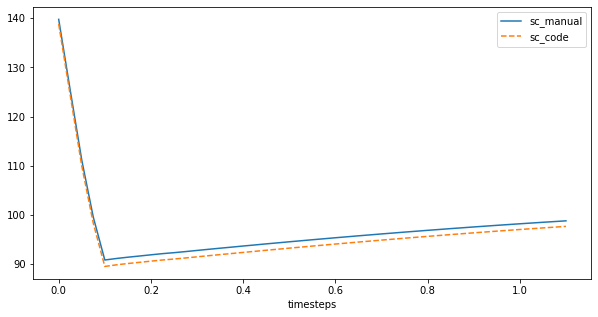

In [23]:
df_comp.plot(
    x="timesteps", 
    y=["sc_manual", "sc_code"], 
    style=["-", "--"],
    figsize=(10,5))

Compute Longitudinal length

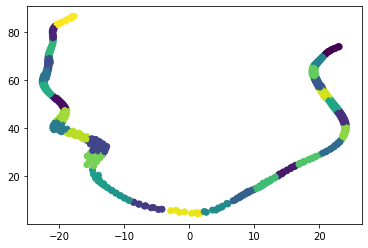

In [31]:
from sklearn.cluster import KMeans

n_clusters = 30
clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(l1[0, :])
labels = clustering.labels_

centers = []
for k in range(n_clusters):
    mask = np.where(labels==k)[0]
    centers.append([np.mean(x[mask], axis=1) for x in l1])

from matplotlib import pyplot as plt
plt.scatter(l1[0, :, 1], l1[0, :, 2], c=labels)
# plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)


In [32]:
def sort_by_zs_ys(xyz):
    zs = xyz[:, 2]
    ys = xyz[:, 1]
    ss = np.sign(ys)*(zs-np.min(zs))
    ids = np.argsort(ss)
    return xyz[ids]

In [33]:
centers = []
for x in l1:
    c = np.asarray([np.mean(x[np.where(labels==k)[0]], axis=0) for k in range(n_clusters)])
    centers.append(sort_by_zs_ys(c))
centers = np.asarray(centers)

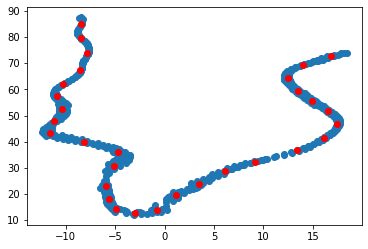

In [34]:
plt.scatter(l1[6, :, 1], l1[6, :, 2])
plt.scatter(centers[6, :, 1], centers[6, :, 2], c="red")

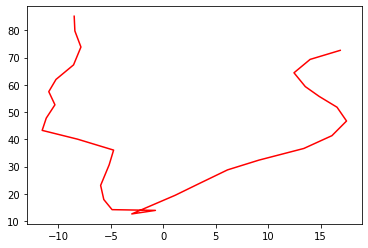

In [35]:
plt.plot(centers[6, :, 1], centers[6, :, 2], c="red")

In [29]:
sl = np.asarray([line_sum(x) for x in centers])
df_comp["sl_manual"] = sl
df_comp["sl_code"] = from_code["global_longitudinal_length_endo_0.0"]

<AxesSubplot:xlabel='timesteps'>

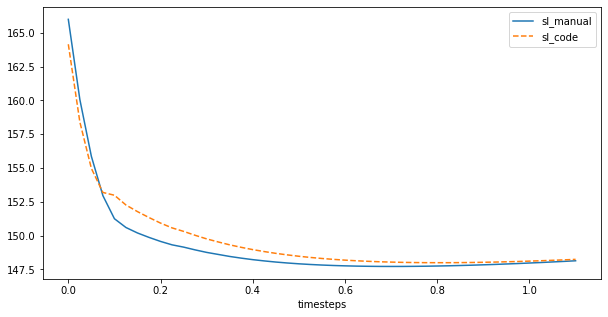

In [30]:
df_comp.plot(
    x="timesteps", 
    y=["sl_manual", "sl_code"], 
    style=["-", "--"],
    figsize=(10,5))